# **ANN (Artificial Neural Network) Forecasting for Daily Acquisition Data**


## **Library**


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from datetime import datetime, timedelta
import requests
from io import BytesIO

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import ParameterGrid

# Scikit-learn metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"TensorFlow version: {tf.__version__}")


## **Konfigurasi**


In [ ]:
# Configuration
# Calculate days until end of 2025
from datetime import datetime, timedelta

def calculate_days_until_end_of_year(target_year=2025):
    """Calculate number of days from today until end of target year"""
    # Berdasarkan ketersediaan data hingga 2025-09-10,
    # kita akan menghitung sisa hari hingga 2025-12-31 terlepas dari tanggal hari ini.
    # Ini memastikan kita meramal hingga akhir tahun sesuai permintaan.
    start_date = datetime(2025, 9, 10) # Assuming data is available until 2025-09-10
    end_of_year = datetime(target_year, 12, 31) # Tanggal akhir peramalan (akhir tahun target)

    days_remaining = (end_of_year - start_date).days # Menghitung selisih hari
    return max(0, days_remaining) # Mengembalikan jumlah hari sisa (minimal 0)

# Menghitung jumlah hari peramalan hingga akhir 2025
FORECAST_DAYS = calculate_days_until_end_of_year(2025)
TEST_SIZE = 0.2  # 20% of data for testing
VALIDATION_SIZE = 0.1  # 10% of training data for validation

# ANN Model Configuration
ANN_CONFIG = {
    'sequence_length': 30,  # Number of previous days to use for prediction
    'n_features': 8,  # Number of input features (jumlah + engineered features)
    'lstm_units': [64, 32],  # LSTM layer units
    'dropout_rate': 0.2,  # Dropout rate
    'dense_units': [32, 16],  # Dense layer units
    'learning_rate': 0.001,  # Learning rate
    'batch_size': 32,  # Batch size
    'epochs': 100,  # Maximum epochs
    'patience': 15,  # Early stopping patience
    'min_delta': 0.001,  # Minimum change to qualify as improvement
}

# Hyperparameter tuning grid
HYPERPARAMETER_GRID = {
    'sequence_length': [20, 30, 45],
    'lstm_units': [[32, 16], [64, 32], [128, 64]],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [16, 32, 64]
}

print(f"Configuration:")
print(f"- Forecast until: December 31, 2025")
print(f"- Forecast days: {FORECAST_DAYS}")
print(f"- Test size: {TEST_SIZE*100}%")
print(f"- Validation size: {VALIDATION_SIZE*100}%")
print(f"- Sequence length: {ANN_CONFIG['sequence_length']} days")
print(f"- LSTM units: {ANN_CONFIG['lstm_units']}")
print(f"- Dropout rate: {ANN_CONFIG['dropout_rate']}")

if FORECAST_DAYS == 0:
    print("⚠️  Warning: 2025 has already passed. Forecast will be empty.")
elif FORECAST_DAYS < 30:
    print(f"⚠️  Warning: Less than 30 days remaining for the forecast period.")


## **Define Indonesian National Holidays**


In [ ]:
# Define Indonesian national holidays affecting Astra sales (2024-2025)
holiday_dates_str = [
    '08/02/2024', # Isra Mi'raj Nabi Muhammad SAW
    '10/02/2024', # Tahun Baru Imlek 2575 Kongzili
    '14/02/2024', # Libur Pemilu
    '11/03/2024', # Hari Suci Nyepi Tahun Baru Saka 1946
    '29/03/2024', # Wafat Yesus Kristus
    '10/04/2024', # Hari Raya Idul Fitri
    '09/05/2024', # Kenaikan Isa Al Masih
    '23/05/2024', # Hari Raya Waisak
    '01/06/2024', # Hari Lahir Pancasila
    '17/06/2024', # Hari Raya Idul Adha 1445 Hijriah
    '07/07/2024', # Tahun Baru Islam 1446 Hijriah
    '17/08/2024', # Hari Kemerdekaan Republik Indonesia
    '16/09/2024', # Maulid Nabi Muhammad SAW
    '27/11/2024', # Pilkada Serentak (Libur)
    '25/12/2024', # Hari Raya Natal
    '01/01/2025', # Tahun Baru 2025 Masehi
    '27/01/2025', # Isra Mi'raj Nabi Muhammad SAW
    '29/01/2025', # Tahun Baru Imlek
    '31/03/2025', # Hari Raya Idul Fitri 1446 Hijiriyah
    '18/04/2025', # Wafat Yesus Kristus
    '20/04/2025', # Kebangkitan Yesus Kristus
    '12/05/2025', # Hari Raya Waisak
    '29/05/2025', # Kenaikan Yesus Kristus
    '01/06/2025', # Hari Lahir Pancasila
    '06/06/2025', # Hari Raya Idul Adha
    '27/06/2025', # Tahun Baru Islam 1447 Hijriyah
    '17/08/2025', # Hari Kemerdekaan Republik Indonesia
    '05/09/2025'  # Maulid Nabi Muhammad SAW
]

# Parse and deduplicate
holiday_dates = pd.to_datetime(holiday_dates_str, format='%d/%m/%Y', dayfirst=True, errors='coerce')
holiday_dates = pd.Series(holiday_dates.dropna().unique()).sort_values()

# Create holiday DataFrame for ANN features
holidays_df = pd.DataFrame({
    'holiday': 'id_holiday',
    'ds': holiday_dates,
    'lower_window': 0,
    'upper_window': 0,
})

# Modify lower and upper window for special holidays
eid_al_fitr_date_2024 = pd.to_datetime('10/04/2024', format='%d/%m/%Y', dayfirst=True)
holidays_df.loc[holidays_df['ds'] == eid_al_fitr_date_2024, 'lower_window'] = -2  # 2 days before
holidays_df.loc[holidays_df['ds'] == eid_al_fitr_date_2024, 'upper_window'] = 5   # 5 days after

new_year_2025 = pd.to_datetime('01/01/2025', format='%d/%m/%Y', dayfirst=True)
holidays_df.loc[holidays_df['ds'] == new_year_2025, 'upper_window'] = 11  # 11 days after

eid_al_fitr_2025 = pd.to_datetime('31/03/2025', format='%d/%m/%Y', dayfirst=True)
holidays_df.loc[holidays_df['ds'] == eid_al_fitr_2025, 'lower_window'] = -2  # 2 days before
holidays_df.loc[holidays_df['ds'] == eid_al_fitr_2025, 'upper_window'] = 6   # 6 days after

print(f"Holidays loaded: {len(holidays_df)} unique dates")
print("\nHolidays with modified windows:")
modified_holidays = holidays_df[(holidays_df['lower_window'] != 0) | (holidays_df['upper_window'] != 0)]
print(modified_holidays.to_string(index=False))


## **Load Data**


In [ ]:
# Load and preprocess the dataset
def load_data():
    """Load data from Google Sheets with error handling"""
    try:
        # URL ke Google Sheets (format Excel)
        url = "https://docs.google.com/spreadsheets/d/12EuA3FX_e3Xh1xRxn13qX2mOKzAkZgE7/export?format=xlsx"

        # Mengunduh file Excel ke dalam memori
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        file_data = BytesIO(response.content)

        # Membaca data Excel ke dalam DataFrame
        df = pd.read_excel(file_data, sheet_name=2, engine='openpyxl')

        print(f"Data loaded successfully!")
        print(f"Shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")

        return df

    except Exception as e:
        print(f"Error loading data: {e}")
        print("Creating sample data for testing...")
        # Generate sample dates
        dates = pd.date_range(start='2024-01-01', end='2025-12-31', freq='D')
        # Generate sample values with seasonal patterns and noise
        values = np.random.randint(50, 200, len(dates)) + np.sin(np.arange(len(dates)) * 2 * np.pi / 365) * 30
        df = pd.DataFrame({'tanggal': dates, 'jumlah': values})
        return df

# Load the data
df = load_data()
print("\nFirst 5 rows:")
display(df.head())
print("\nLast 5 rows:")
display(df.tail())


## **Preprocessing Data**


In [ ]:
# Data preprocessing for ANN
def preprocess_data_for_ann(df, holidays_df, sequence_length=30):
    """Preprocess data for ANN time series forecasting"""
    # Convert tanggal to datetime
    df['tanggal'] = pd.to_datetime(df['tanggal'], errors='coerce')
    df['jumlah'] = pd.to_numeric(df['jumlah'], errors='coerce')
    df = df.dropna()
    df = df.sort_values('tanggal').reset_index(drop=True)
    
    # Create time-based features
    df['year'] = df['tanggal'].dt.year
    df['month'] = df['tanggal'].dt.month
    df['day'] = df['tanggal'].dt.day
    df['dayofweek'] = df['tanggal'].dt.dayofweek
    df['dayofyear'] = df['tanggal'].dt.dayofyear
    df['quarter'] = df['tanggal'].dt.quarter
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # Create holiday features
    df['is_holiday'] = 0
    df['days_to_holiday'] = 0
    df['days_from_holiday'] = 0
    
    for _, holiday in holidays_df.iterrows():
        holiday_date = holiday['ds']
        lower_window = holiday['lower_window']
        upper_window = holiday['upper_window']
        
        # Mark holiday period
        holiday_start = holiday_date + pd.Timedelta(days=lower_window)
        holiday_end = holiday_date + pd.Timedelta(days=upper_window)
        
        holiday_mask = (df['tanggal'] >= holiday_start) & (df['tanggal'] <= holiday_end)
        df.loc[holiday_mask, 'is_holiday'] = 1
        
        # Calculate days to/from holiday
        days_diff = (df['tanggal'] - holiday_date).dt.days
        df.loc[days_diff >= 0, 'days_from_holiday'] = np.minimum(
            df.loc[days_diff >= 0, 'days_from_holiday'], 
            days_diff[days_diff >= 0]
        )
        df.loc[days_diff < 0, 'days_to_holiday'] = np.minimum(
            df.loc[days_diff < 0, 'days_to_holiday'], 
            -days_diff[days_diff < 0]
        )
    
    # Create lag features
    for lag in [1, 7, 14, 30]:
        df[f'jumlah_lag_{lag}'] = df['jumlah'].shift(lag)
    
    # Create rolling statistics
    for window in [7, 14, 30]:
        df[f'jumlah_rolling_mean_{window}'] = df['jumlah'].rolling(window=window).mean()
        df[f'jumlah_rolling_std_{window}'] = df['jumlah'].rolling(window=window).std()
    
    # Create trend features
    df['jumlah_diff'] = df['jumlah'].diff()
    df['jumlah_pct_change'] = df['jumlah'].pct_change()
    
    # Fill NaN values
    df = df.fillna(method='bfill').fillna(method='ffill')
    
    return df

# Preprocess the data
df_processed = preprocess_data_for_ann(df, holidays_df, ANN_CONFIG['sequence_length'])

print("Data Info:")
print(df_processed.info())
print("\nData Statistics:")
print(df_processed.describe())
print(f"\nDate range: {df_processed['tanggal'].min()} to {df_processed['tanggal'].max()}")
print(f"Total days: {len(df_processed)}")
print(f"Missing values: {df_processed.isnull().sum().sum()}")


## **Feature Engineering and Scaling**


In [ ]:
# Feature engineering and scaling for ANN
def prepare_ann_data(df, sequence_length=30, test_size=0.2, val_size=0.1):
    """Prepare data for ANN training"""
    # Select features for ANN
    feature_columns = [
        'jumlah', 'year', 'month', 'day', 'dayofweek', 'dayofyear', 'quarter', 'is_weekend',
        'is_holiday', 'days_to_holiday', 'days_from_holiday',
        'jumlah_lag_1', 'jumlah_lag_7', 'jumlah_lag_14', 'jumlah_lag_30',
        'jumlah_rolling_mean_7', 'jumlah_rolling_mean_14', 'jumlah_rolling_mean_30',
        'jumlah_rolling_std_7', 'jumlah_rolling_std_14', 'jumlah_rolling_std_30',
        'jumlah_diff', 'jumlah_pct_change'
    ]
    
    # Create feature matrix
    X = df[feature_columns].values
    y = df['jumlah'].values
    
    # Split data chronologically
    n_samples = len(X)
    test_start = int(n_samples * (1 - test_size))
    val_start = int(test_start * (1 - val_size))
    
    X_train = X[:val_start]
    X_val = X[val_start:test_start]
    X_test = X[test_start:]
    
    y_train = y[:val_start]
    y_val = y[val_start:test_start]
    y_test = y[test_start:]
    
    # Scale features
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)
    
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    
    # For ANN, we don't need sequences - use all data points
    # Remove the first sequence_length points to match LSTM approach
    X_train_final = X_train_scaled[sequence_length:]
    X_val_final = X_val_scaled[sequence_length:]
    X_test_final = X_test_scaled[sequence_length:]
    
    y_train_final = y_train_scaled[sequence_length:]
    y_val_final = y_val_scaled[sequence_length:]
    y_test_final = y_test_scaled[sequence_length:]
    
    return {
        'X_train': X_train_final, 'y_train': y_train_final,
        'X_val': X_val_final, 'y_val': y_val_final,
        'X_test': X_test_final, 'y_test': y_test_final,
        'scaler_X': scaler_X, 'scaler_y': scaler_y,
        'feature_columns': feature_columns,
        'train_dates': df['tanggal'][:val_start].iloc[sequence_length:].values,
        'val_dates': df['tanggal'][val_start:test_start].iloc[sequence_length:].values,
        'test_dates': df['tanggal'][test_start:].iloc[sequence_length:].values
    }

# Prepare data for ANN
ann_data = prepare_ann_data(df_processed, ANN_CONFIG['sequence_length'], TEST_SIZE, VALIDATION_SIZE)

print(f"Training data shape: {ann_data['X_train'].shape}")
print(f"Validation data shape: {ann_data['X_val'].shape}")
print(f"Test data shape: {ann_data['X_test'].shape}")
print(f"Number of features: {ann_data['X_train'].shape[2]}")
print(f"Sequence length: {ANN_CONFIG['sequence_length']}")


## **ANN Model Architecture**


In [ ]:
# ANN Model Architecture
def create_ann_model(config, n_features):
    """Create ANN model for time series forecasting"""
    model = Sequential()
    
    # Input layer
    model.add(Dense(
        units=config['dense_units'][0],
        activation='relu',
        input_shape=(n_features,),
        kernel_regularizer=l1_l2(l1=0.01, l2=0.01)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(config['dropout_rate']))
    
    # Hidden layers
    for units in config['dense_units'][1:]:
        model.add(Dense(units, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(config['dropout_rate']))
    
    # Additional hidden layers for better learning
    model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(config['dropout_rate']))
    
    model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(config['dropout_rate']))
    
    # Output layer
    model.add(Dense(1, activation='linear'))
    
    # Compile model
    optimizer = Adam(learning_rate=config['learning_rate'])
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', 'mape']
    )
    
    return model

# Create the model
model = create_ann_model(ANN_CONFIG, ann_data['X_train'].shape[2])

# Display model summary
print("ANN Model Architecture:")
model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=ANN_CONFIG['patience'],
        min_delta=ANN_CONFIG['min_delta'],
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_ann_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


## **Model Training**


In [ ]:
# Train the ANN model
print("Training ANN Model...")
print("="*50)

# Train the model
history = model.fit(
    ann_data['X_train'], ann_data['y_train'],
    validation_data=(ann_data['X_val'], ann_data['y_val']),
    epochs=ANN_CONFIG['epochs'],
    batch_size=ANN_CONFIG['batch_size'],
    callbacks=callbacks,
    verbose=1
)

# Load the best model
model.load_weights('best_ann_model.h5')

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# MAE
axes[0, 1].plot(history.history['mae'], label='Training MAE')
axes[0, 1].plot(history.history['val_mae'], label='Validation MAE')
axes[0, 1].set_title('Model MAE')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()
axes[0, 1].grid(True)

# MAPE
axes[1, 0].plot(history.history['mape'], label='Training MAPE')
axes[1, 0].plot(history.history['val_mape'], label='Validation MAPE')
axes[1, 0].set_title('Model MAPE')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('MAPE')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Learning rate (if available)
if 'lr' in history.history:
    axes[1, 1].plot(history.history['lr'])
    axes[1, 1].set_title('Learning Rate')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True)
else:
    axes[1, 1].text(0.5, 0.5, 'Learning Rate\nNot Available', 
                    ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Learning Rate')

plt.tight_layout()
plt.show()

print(f"\nTraining completed!")
print(f"Best validation loss: {min(history.history['val_loss']):.6f}")
print(f"Best validation MAE: {min(history.history['val_mae']):.6f}")
print(f"Best validation MAPE: {min(history.history['val_mape']):.6f}")


## **Model Evaluation**


In [ ]:
# Model evaluation and prediction
def evaluate_model(model, X, y, scaler_y, dates, set_name):
    """Evaluate model and return predictions and metrics"""
    # Make predictions
    y_pred_scaled = model.predict(X, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = scaler_y.inverse_transform(y.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    def calculate_mape(y_true, y_pred):
        """Calculate MAPE, handling cases where y_true is zero."""
        non_zero_indices = y_true > 0
        if np.sum(non_zero_indices) == 0:
            return np.nan
        return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100
    
    def calculate_smape(y_true, y_pred):
        """Calculate SMAPE, handling cases where y_true + y_pred is zero."""
        numerator = np.abs(y_pred - y_true)
        denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
        ratio = np.where(denominator == 0, 0, numerator / denominator)
        return np.mean(ratio) * 100
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = calculate_mape(y_true, y_pred)
    smape = calculate_smape(y_true, y_pred)
    
    print(f"{set_name} accuracy (ANN):")
    print(f"- RMSE: {rmse:.2f}")
    print(f"- MAE:  {mae:.2f}")
    print(f"- MAPE: {mape:.2f}%")
    print(f"- SMAPE: {smape:.2f}%")
    
    return {
        'y_true': y_true,
        'y_pred': y_pred,
        'dates': dates,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'smape': smape
    }

# Evaluate on all sets
train_results = evaluate_model(
    model, ann_data['X_train'], ann_data['y_train'], 
    ann_data['scaler_y'], ann_data['train_dates'], "Train"
)

val_results = evaluate_model(
    model, ann_data['X_val'], ann_data['y_val'], 
    ann_data['scaler_y'], ann_data['val_dates'], "Validation"
)

test_results = evaluate_model(
    model, ann_data['X_test'], ann_data['y_test'], 
    ann_data['scaler_y'], ann_data['test_dates'], "Test"
)


## **Visualisasi Hasil**


In [ ]:
# Visualization of results
plt.figure(figsize=(16, 10))

# Plot 1: Training results
plt.subplot(2, 2, 1)
plt.plot(train_results['dates'], train_results['y_true'], label='Actual', color='tab:blue', alpha=0.8)
plt.plot(train_results['dates'], train_results['y_pred'], label='Predicted', color='tab:orange', alpha=0.7, linestyle='--')
plt.title('ANN - Training: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Jumlah')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 2: Validation results
plt.subplot(2, 2, 2)
plt.plot(val_results['dates'], val_results['y_true'], label='Actual', color='tab:green', alpha=0.8)
plt.plot(val_results['dates'], val_results['y_pred'], label='Predicted', color='tab:red', alpha=0.7, linestyle='--')
plt.title('ANN - Validation: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Jumlah')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 3: Test results
plt.subplot(2, 2, 3)
plt.plot(test_results['dates'], test_results['y_true'], label='Actual', color='tab:purple', alpha=0.8)
plt.plot(test_results['dates'], test_results['y_pred'], label='Predicted', color='tab:brown', alpha=0.7, linestyle='--')
plt.title('ANN - Test: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Jumlah')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 4: All results combined
plt.subplot(2, 2, 4)
plt.plot(train_results['dates'], train_results['y_true'], label='Train (actual)', color='tab:blue', alpha=0.6)
plt.plot(train_results['dates'], train_results['y_pred'], label='Train (pred)', color='tab:orange', alpha=0.6, linestyle='--')
plt.plot(val_results['dates'], val_results['y_true'], label='Val (actual)', color='tab:green', alpha=0.8)
plt.plot(val_results['dates'], val_results['y_pred'], label='Val (pred)', color='tab:red', alpha=0.8, linestyle='--')
plt.plot(test_results['dates'], test_results['y_true'], label='Test (actual)', color='tab:purple', alpha=0.8)
plt.plot(test_results['dates'], test_results['y_pred'], label='Test (pred)', color='tab:brown', alpha=0.8, linestyle='--')

# Add vertical lines to separate sets
val_start_idx = len(train_results['dates'])
test_start_idx = val_start_idx + len(val_results['dates'])
plt.axvline(x=train_results['dates'][-1], color='black', linestyle='--', alpha=0.7, label='Train/Val split')
plt.axvline(x=val_results['dates'][-1], color='black', linestyle='--', alpha=0.7, label='Val/Test split')

plt.title('ANN - All Results Combined')
plt.xlabel('Date')
plt.ylabel('Jumlah')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Scatter plots for accuracy assessment
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training scatter
axes[0].scatter(train_results['y_true'], train_results['y_pred'], alpha=0.6, color='tab:blue')
axes[0].plot([train_results['y_true'].min(), train_results['y_true'].max()], 
             [train_results['y_true'].min(), train_results['y_true'].max()], 'r--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title(f'Training (R² = {np.corrcoef(train_results["y_true"], train_results["y_pred"])[0,1]**2:.3f})')
axes[0].grid(True, alpha=0.3)

# Validation scatter
axes[1].scatter(val_results['y_true'], val_results['y_pred'], alpha=0.6, color='tab:green')
axes[1].plot([val_results['y_true'].min(), val_results['y_true'].max()], 
             [val_results['y_true'].min(), val_results['y_true'].max()], 'r--', lw=2)
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title(f'Validation (R² = {np.corrcoef(val_results["y_true"], val_results["y_pred"])[0,1]**2:.3f})')
axes[1].grid(True, alpha=0.3)

# Test scatter
axes[2].scatter(test_results['y_true'], test_results['y_pred'], alpha=0.6, color='tab:purple')
axes[2].plot([test_results['y_true'].min(), test_results['y_true'].max()], 
             [test_results['y_true'].min(), test_results['y_true'].max()], 'r--', lw=2)
axes[2].set_xlabel('Actual')
axes[2].set_ylabel('Predicted')
axes[2].set_title(f'Test (R² = {np.corrcoef(test_results["y_true"], test_results["y_pred"])[0,1]**2:.3f})')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## **Forecasting Pipeline**


In [ ]:
# Forecasting pipeline for future predictions
def create_forecast_data(df_processed, last_date, forecast_days, sequence_length, scaler_X, feature_columns):
    """Create forecast data for future predictions"""
    # Generate future dates
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days, freq='D')
    
    # Create future DataFrame with same structure as training data
    future_df = pd.DataFrame({'tanggal': future_dates})
    
    # Add time-based features
    future_df['year'] = future_df['tanggal'].dt.year
    future_df['month'] = future_df['tanggal'].dt.month
    future_df['day'] = future_df['tanggal'].dt.day
    future_df['dayofweek'] = future_df['tanggal'].dt.dayofweek
    future_df['dayofyear'] = future_df['tanggal'].dt.dayofyear
    future_df['quarter'] = future_df['tanggal'].dt.quarter
    future_df['is_weekend'] = (future_df['dayofweek'] >= 5).astype(int)
    
    # Initialize other features with zeros (will be updated during forecasting)
    for col in ['jumlah', 'is_holiday', 'days_to_holiday', 'days_from_holiday']:
        future_df[col] = 0
    
    for lag in [1, 7, 14, 30]:
        future_df[f'jumlah_lag_{lag}'] = 0
    
    for window in [7, 14, 30]:
        future_df[f'jumlah_rolling_mean_{window}'] = 0
        future_df[f'jumlah_rolling_std_{window}'] = 0
    
    future_df['jumlah_diff'] = 0
    future_df['jumlah_pct_change'] = 0
    
    return future_df

def forecast_future(model, df_processed, ann_data, forecast_days, sequence_length):
    """Generate future forecasts using the trained ANN model"""
    # Get last date from processed data
    last_date = df_processed['tanggal'].max()
    
    # Create future data structure
    future_df = create_forecast_data(
        df_processed, last_date, forecast_days, sequence_length,
        ann_data['scaler_X'], ann_data['feature_columns']
    )
    
    predictions = []
    
    for i in range(forecast_days):
        # Create feature vector for this day
        feature_vector = future_df.iloc[i][ann_data['feature_columns']].values.reshape(1, -1)
        feature_vector_scaled = ann_data['scaler_X'].transform(feature_vector)
        
        # Make prediction using ANN
        pred_scaled = model.predict(feature_vector_scaled, verbose=0)
        pred_actual = ann_data['scaler_y'].inverse_transform(pred_scaled.reshape(-1, 1)).flatten()[0]
        
        # Apply floor constraint (minimum 0)
        pred_actual = max(0, pred_actual)
        predictions.append(pred_actual)
        
        # Update future_df with prediction
        future_df.loc[i, 'jumlah'] = pred_actual
        
        # Update lag features for next prediction
        if i > 0:
            future_df.loc[i, 'jumlah_lag_1'] = predictions[i-1]
        if i >= 7:
            future_df.loc[i, 'jumlah_lag_7'] = predictions[i-7]
        if i >= 14:
            future_df.loc[i, 'jumlah_lag_14'] = predictions[i-14]
        if i >= 30:
            future_df.loc[i, 'jumlah_lag_30'] = predictions[i-30]
        
        # Update rolling statistics
        if i >= 7:
            future_df.loc[i, 'jumlah_rolling_mean_7'] = np.mean(predictions[max(0, i-6):i+1])
            future_df.loc[i, 'jumlah_rolling_std_7'] = np.std(predictions[max(0, i-6):i+1])
        if i >= 14:
            future_df.loc[i, 'jumlah_rolling_mean_14'] = np.mean(predictions[max(0, i-13):i+1])
            future_df.loc[i, 'jumlah_rolling_std_14'] = np.std(predictions[max(0, i-13):i+1])
        if i >= 30:
            future_df.loc[i, 'jumlah_rolling_mean_30'] = np.mean(predictions[max(0, i-29):i+1])
            future_df.loc[i, 'jumlah_rolling_std_30'] = np.std(predictions[max(0, i-29):i+1])
        
        # Update difference features
        if i > 0:
            future_df.loc[i, 'jumlah_diff'] = predictions[i] - predictions[i-1]
            future_df.loc[i, 'jumlah_pct_change'] = (predictions[i] - predictions[i-1]) / max(predictions[i-1], 1e-8)
    
    return future_df, predictions

# Generate forecasts
print("Generating future forecasts...")
future_df, predictions = forecast_future(
    model, df_processed, ann_data, FORECAST_DAYS, ANN_CONFIG['sequence_length']
)

print(f"Forecast generated for {len(predictions)} days")
print(f"Forecast period: {future_df['tanggal'].min().date()} to {future_df['tanggal'].max().date()}")
print(f"Average predicted value: {np.mean(predictions):.2f}")
print(f"Min predicted value: {np.min(predictions):.2f}")
print(f"Max predicted value: {np.max(predictions):.2f}")


## **Forecast Visualization**


In [ ]:
# Visualize forecasts
plt.figure(figsize=(16, 10))

# Plot 1: Historical data with forecasts
plt.subplot(2, 2, 1)
plt.plot(df_processed['tanggal'], df_processed['jumlah'], label='Historical Data', color='tab:blue', alpha=0.8)
plt.plot(future_df['tanggal'], predictions, label='LSTM Forecast', color='tab:red', linewidth=2)
plt.axvline(x=df_processed['tanggal'].max(), color='black', linestyle='--', alpha=0.7, label='Forecast Start')
plt.title('ANN - Historical Data and Future Forecast')
plt.xlabel('Date')
plt.ylabel('Jumlah')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 2: Recent data with forecasts (last 6 months)
recent_cutoff = df_processed['tanggal'].max() - pd.Timedelta(days=180)
recent_data = df_processed[df_processed['tanggal'] >= recent_cutoff]
plt.subplot(2, 2, 2)
plt.plot(recent_data['tanggal'], recent_data['jumlah'], label='Recent Historical', color='tab:blue', alpha=0.8)
plt.plot(future_df['tanggal'], predictions, label='ANN Forecast', color='tab:red', linewidth=2)
plt.axvline(x=df_processed['tanggal'].max(), color='black', linestyle='--', alpha=0.7, label='Forecast Start')
plt.title('ANN - Recent Data and Forecast (Last 6 Months)')
plt.xlabel('Date')
plt.ylabel('Jumlah')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 3: Forecast only with confidence bands
plt.subplot(2, 2, 3)
# Calculate simple confidence intervals based on historical variance
historical_std = np.std(df_processed['jumlah'])
confidence_upper = np.array(predictions) + 1.96 * historical_std
confidence_lower = np.maximum(np.array(predictions) - 1.96 * historical_std, 0)  # Apply floor constraint

plt.plot(future_df['tanggal'], predictions, label='LSTM Forecast', color='tab:red', linewidth=2)
plt.fill_between(future_df['tanggal'], confidence_lower, confidence_upper, 
                 color='tab:red', alpha=0.2, label='95% Confidence Interval')
plt.title('ANN - Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Jumlah')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 4: Monthly aggregation of forecast
plt.subplot(2, 2, 4)
monthly_forecast = future_df.groupby(future_df['tanggal'].dt.to_period('M'))['jumlah'].sum()
monthly_forecast.plot(kind='bar', color='tab:orange', alpha=0.7)
plt.title('ANN - Monthly Forecast Aggregation')
plt.xlabel('Month')
plt.ylabel('Total Jumlah')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional forecast analysis
print("\nForecast Analysis:")
print("="*50)
print(f"Total forecast days: {len(predictions)}")
print(f"Average daily forecast: {np.mean(predictions):.2f}")
print(f"Median daily forecast: {np.median(predictions):.2f}")
print(f"Standard deviation: {np.std(predictions):.2f}")
print(f"Min daily forecast: {np.min(predictions):.2f}")
print(f"Max daily forecast: {np.max(predictions):.2f}")

# Weekly patterns in forecast
future_df['day_name'] = future_df['tanggal'].dt.day_name()
weekly_forecast = future_df.groupby('day_name')['jumlah'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

print(f"\nWeekly Pattern in Forecast:")
for day, avg in weekly_forecast.items():
    print(f"{day}: {avg:.2f}")


## **Export Results and Monthly Summary**


In [ ]:
# Export forecast results
def export_forecast_results(future_df, predictions, filename='ann_forecast_until_2025.csv'):
    """Export forecast results to CSV"""
    # Create output DataFrame
    output_df = future_df[['tanggal', 'jumlah']].copy()
    output_df = output_df.rename(columns={'tanggal': 'date', 'jumlah': 'forecast'})
    
    # Add additional information
    output_df['year'] = output_df['date'].dt.year
    output_df['month'] = output_df['date'].dt.month
    output_df['day'] = output_df['date'].dt.day
    output_df['day_name'] = output_df['date'].dt.day_name()
    output_df['quarter'] = output_df['date'].dt.quarter
    
    # Calculate confidence intervals
    historical_std = np.std(df_processed['jumlah'])
    output_df['lower_bound'] = np.maximum(output_df['forecast'] - 1.96 * historical_std, 0)
    output_df['upper_bound'] = output_df['forecast'] + 1.96 * historical_std
    
    # Save to CSV
    output_df.to_csv(filename, index=False)
    print(f"Forecast saved to {filename}")
    
    return output_df

# Export results
forecast_output = export_forecast_results(future_df, predictions)

# Display first 10 rows
print("\nFirst 10 rows of forecast:")
print(forecast_output.head(10).to_string(index=False))

# Monthly forecast summary
print("\n" + "="*60)
print("MONTHLY FORECAST SUMMARY (September - December 2025)")
print("="*60)

# Filter data for September 2025 (actual + forecast)
sept_2025_actual = df_processed[(df_processed['tanggal'] >= '2025-09-01') & 
                                (df_processed['tanggal'] <= '2025-09-10')].copy()
sept_2025_forecast = future_df[(future_df['tanggal'] >= '2025-09-11') & 
                               (future_df['tanggal'] <= '2025-09-30')].copy()

# Calculate totals
total_sept_actual = sept_2025_actual['jumlah'].sum()
total_sept_forecast = sept_2025_forecast['jumlah'].sum()
total_sept_2025 = total_sept_actual + total_sept_forecast

# Monthly aggregation for October-December
monthly_forecast = future_df.groupby(future_df['tanggal'].dt.to_period('M'))['jumlah'].sum()

# Create summary table
monthly_summary = pd.DataFrame({
    'Bulan': ['September', 'Oktober', 'November', 'Desember'],
    'Jumlah': [
        total_sept_2025,
        monthly_forecast.get('2025-10', 0),
        monthly_forecast.get('2025-11', 0),
        monthly_forecast.get('2025-12', 0)
    ]
})

print(monthly_summary.to_string(index=False))

# Visualize monthly summary
plt.figure(figsize=(12, 6))

# Create stacked bar for September (actual + forecast)
sept_data = pd.DataFrame({
    'Bulan': ['September', 'September'],
    'Sumber': ['Aktual (1-10)', 'Peramalan (11-30)'],
    'Jumlah': [total_sept_actual, total_sept_forecast]
})

# Create data for other months
other_months = monthly_summary[monthly_summary['Bulan'] != 'September'].copy()
other_months['Sumber'] = 'Peramalan'

# Combine data for plotting
plot_data = pd.concat([sept_data, other_months], ignore_index=True)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot September as stacked bars
sept_actual_bar = ax.bar(0, total_sept_actual, color='tab:blue', alpha=0.7, label='September (Aktual 1-10)')
sept_forecast_bar = ax.bar(0, total_sept_forecast, bottom=total_sept_actual, color='tab:orange', alpha=0.7, label='September (Peramalan 11-30)')

# Plot other months
months = ['September', 'Oktober', 'November', 'Desember']
values = [total_sept_2025, 
          monthly_forecast.get('2025-10', 0),
          monthly_forecast.get('2025-11', 0),
          monthly_forecast.get('2025-12', 0)]

bars = ax.bar(range(1, 4), values[1:], color='tab:green', alpha=0.7, label='Peramalan')

# Add value labels on bars
for i, (bar, value) in enumerate(zip([sept_actual_bar, sept_forecast_bar] + list(bars), values)):
    if i == 0:  # September actual
        ax.text(bar[0].get_x() + bar[0].get_width()/2, bar[0].get_height()/2, 
                f'{int(value)}', ha='center', va='center', fontweight='bold')
    elif i == 1:  # September forecast
        ax.text(bar[0].get_x() + bar[0].get_width()/2, total_sept_actual + bar[0].get_height()/2, 
                f'{int(value)}', ha='center', va='center', fontweight='bold')
    else:  # Other months
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
                f'{int(value)}', ha='center', va='center', fontweight='bold')

ax.set_xlabel('Bulan')
ax.set_ylabel('Total Jumlah')
ax.set_title('Peramalan Akuisisi Bulanan (September - Desember 2025) - ANN')
ax.set_xticks(range(4))
ax.set_xticklabels(months)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal forecast for Q4 2025: {monthly_summary['Jumlah'].sum():,.0f}")
print(f"Average daily forecast: {monthly_summary['Jumlah'].sum() / len(forecast_output):.2f}")


## **Model Summary and Comparison**


In [ ]:
# Model summary and performance comparison
print("\n" + "="*80)
print("🎯 ANN TIME SERIES FORECASTING - COMPLETED SUCCESSFULLY! 🎯")
print("="*80)

print("\n📋 WHAT WAS ACCOMPLISHED:")
print("✅ Implemented ANN neural network for time series forecasting")
print("✅ Added comprehensive feature engineering (holidays, seasonality, lags, rolling stats)")
print("✅ Implemented proper train/validation/test split with time series considerations")
print("✅ Applied floor constraints to prevent negative predictions")
print("✅ Generated forecast until end of 2025 with confidence intervals")
print("✅ Exported future forecast to CSV with detailed information")

print("\n📊 MODEL PERFORMANCE (ANN):")
print(f"   • Train RMSE: {train_results['rmse']:.2f} | Train MAPE: {train_results['mape']:.2f}%")
print(f"   • Val RMSE: {val_results['rmse']:.2f} | Val MAPE: {val_results['mape']:.2f}%")
print(f"   • Test RMSE: {test_results['rmse']:.2f} | Test MAPE: {test_results['mape']:.2f}%")

print("\n🔧 KEY FEATURES IMPLEMENTED:")
print("   • ANN architecture with multiple dense layers")
print("   • Batch normalization and dropout for regularization")
print("   • Holiday encoding with window effects")
print("   • Lag features (1, 7, 14, 30 days)")
print("   • Rolling statistics (7, 14, 30 days)")
print("   • Time-based features (day of week, month, quarter)")
print("   • Early stopping and learning rate reduction")
print("   • Floor constraint (minimum 0) for realistic predictions")

print("\n📈 FORECAST SUMMARY:")
print(f"   • Forecast period: {forecast_output['date'].min().date()} to {forecast_output['date'].max().date()}")
print(f"   • Total forecast days: {len(forecast_output)}")
print(f"   • Average daily forecast: {np.mean(predictions):.2f}")
print(f"   • Q4 2025 total forecast: {monthly_summary['Jumlah'].sum():,.0f}")

print("\n📁 FILES CREATED:")
print("   • ann_forecast_until_2025.csv (detailed forecast)")
print("   • best_ann_model.h5 (trained model weights)")

print("\n🚀 ADVANTAGES OF ANN OVER PROPHET:")
print("   • Can capture complex non-linear patterns")
print("   • Handles multiple input features simultaneously")
print("   • More flexible for custom feature engineering")
print("   • Better at learning from sequential patterns")
print("   • Can be easily retrained with new data")

print("\n⚠️  CONSIDERATIONS:")
print("   • Requires more data preprocessing")
print("   • More computationally intensive")
print("   • May need more tuning for optimal performance")
print("   • Less interpretable than Prophet")

print("\n" + "="*80)
print("Thank you for using the ANN Forecasting System! 🎉")
print("="*80)


# **Prophet Forecasting for Daily Acquisition Data**

## **Library**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from datetime import datetime, timedelta
import requests
from io import BytesIO

# Prophet
from prophet import Prophet

# Scikit-learn metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2


## **Konfigurasi**

In [ ]:
# Configuration
# Calculate days until end of 2025
from datetime import datetime, timedelta

def calculate_days_until_end_of_year(target_year=2025):
    """Calculate number of days from today until end of target year"""

    # Berdasarkan ketersediaan data hingga 2025-09-10,
    # kita akan menghitung sisa hari hingga 2025-12-31 terlepas dari tanggal hari ini.
    # Ini memastikan kita meramal hingga akhir tahun sesuai permintaan.
    start_date = datetime(2025, 9, 10) # Assuming data is available until 2025-09-10 # Asumsi data tersedia hingga 2025-09-10
    end_of_year = datetime(target_year, 12, 31) # Tanggal akhir peramalan (akhir tahun target)

    days_remaining = (end_of_year - start_date).days # Menghitung selisih hari
    return max(0, days_remaining) # Mengembalikan jumlah hari sisa (minimal 0)

# Menghitung jumlah hari peramalan hingga akhir 2025
FORECAST_DAYS = calculate_days_until_end_of_year(2025)
TEST_SIZE = 0.2  # 30% of data for testing # Ukuran data untuk pengujian (30%)
VALIDATION_SIZE = 0.1  # 10% of training data for validation # Ukuran data untuk validasi (10% dari data latih)

# Parameter default Prophet (bisa disetel/tuning)
PROPHET_PARAMS = {
    'growth': 'linear', # Jenis pertumbuhan: linear
    'seasonality_mode': 'additive', # Mode musiman: aditif
    'weekly_seasonality': True, # Aktifkan musiman mingguan
    'yearly_seasonality': True, # Aktifkan musiman tahunan
    'daily_seasonality': False, # Nonaktifkan musiman harian
}

print(f"Configuration:") # Mencetak judul konfigurasi
print(f"- Forecast until: December 31, 2025") # Mencetak tanggal akhir peramalan
print(f"- Forecast days: {FORECAST_DAYS}") # Mencetak jumlah hari peramalan
print(f"- Test size: {TEST_SIZE*100}%") # Mencetak ukuran data uji dalam persen
print(f"- Validation size: {VALIDATION_SIZE*100}%") # Mencetak ukuran data validasi dalam persen
print(f"- Prophet params: {PROPHET_PARAMS}") # Mencetak parameter Prophet

if FORECAST_DAYS == 0: # Jika jumlah hari peramalan 0
    print("⚠️  Warning: 2025 has already passed. Forecast will be empty.") # Cetak peringatan tahun sudah lewat
elif FORECAST_DAYS < 30: # Jika jumlah hari peramalan kurang dari 30
    print(f"⚠️  Warning: Less than 30 days remaining for the forecast period.") # Cetak peringatan sisa hari kurang dari 30

Configuration:
- Forecast until: December 31, 2025
- Forecast days: 112
- Test size: 20.0%
- Validation size: 10.0%
- Prophet params: {'growth': 'linear', 'seasonality_mode': 'additive', 'weekly_seasonality': True, 'yearly_seasonality': True, 'daily_seasonality': False}


## **Define Indonesian National Holidays**

In [ ]:
# Define Indonesian national holidays affecting Astra sales (2024-2025)
holiday_dates_str = [
    '08/02/2024', # Isra Mi'raj Nabi Muhammad SAW
    '10/02/2024', # Tahun Baru Imlek 2575 Kongzili
    '14/02/2024', # Libur Pemilu
    '11/03/2024', # Hari Suci Nyepi Tahun Baru Saka 1946
    '29/03/2024', # Wafat Yesus Kristus
    '10/04/2024', # Hari Raya Idul Fitri
    '09/05/2024', # Kenaikan Isa Al Masih
    '23/05/2024', # Hari Raya Waisak
    '01/06/2024', # Hari Lahir Pancasila
    '17/06/2024', # Hari Raya Idul Adha 1445 Hijriah
    '07/07/2024', # Tahun Baru Islam 1446 Hijriah
    '17/08/2024', # Hari Kemerdekaan Republik Indonesia
    '16/09/2024', # Maulid Nabi Muhammad SAW
    '27/11/2024', # Pilkada Serentak (Libur)
    '25/12/2024', # Hari Raya Natal
    '01/01/2025', # Tahun Baru 2025 Masehi
    '27/01/2025', # Isra Mi'raj Nabi Muhammad SAW
    '29/01/2025', # Tahun Baru Imlek
    '31/03/2025', # Hari Raya Idul Fitri 1446 Hijiriyah
    '18/04/2025', # Wafat Yesus Kristus
    '20/04/2025', # Kebangkitan Yesus Kristus
    '12/05/2025', # Hari Raya Waisak
    '29/05/2025', # Kenaikan Yesus Kristus
    '01/06/2025', # Hari Lahir Pancasila
    '06/06/2025', # Hari Raya Idul Adha
    '27/06/2025', # Tahun Baru Islam 1447 Hijriyah
    '17/08/2025', # Hari Kemerdekaan Republik Indonesia
    '05/09/2025'  # Maulid Nabi Muhammad SAW
]

# Parse and deduplicate
holiday_dates = pd.to_datetime(holiday_dates_str, format='%d/%m/%Y', dayfirst=True, errors='coerce')
holiday_dates = pd.Series(holiday_dates.dropna().unique()).sort_values()

holidays_df = pd.DataFrame({
    'holiday': 'id_holiday',
    'ds': holiday_dates,
    'lower_window': 0,
    'upper_window': 0,
})

# Modify lower and upper window for '10/04/2024' (Idul Fitri 2024)
# Note: lower_window should be <= 0 (negative values for days before holiday)
eid_al_fitr_date_2024 = pd.to_datetime('10/04/2024', format='%d/%m/%Y', dayfirst=True)
holidays_df.loc[holidays_df['ds'] == eid_al_fitr_date_2024, 'lower_window'] = -2  # 2 days before
holidays_df.loc[holidays_df['ds'] == eid_al_fitr_date_2024, 'upper_window'] = 5   # 5 days after

# Modify upper window for '01/01/2025' (Tahun Baru diiringi dengan kenaikan pajak 12%)
new_year_2025 = pd.to_datetime('01/01/2025', format='%d/%m/%Y', dayfirst=True)
holidays_df.loc[holidays_df['ds'] == new_year_2025, 'upper_window'] = 11  # 11 days after Tahun baru dealer tutup

# Modify lower and upper window for '31/03/2025' (Idul Fitri 2025)
eid_al_fitr_2025 = pd.to_datetime('31/03/2025', format='%d/%m/%Y', dayfirst=True)
holidays_df.loc[holidays_df['ds'] == eid_al_fitr_2025, 'lower_window'] = -2  # 2 days before
holidays_df.loc[holidays_df['ds'] == eid_al_fitr_2025, 'upper_window'] = 6   # 6 days after

print(f"Holidays loaded: {len(holidays_df)} unique dates")
print("\nHolidays with modified windows:")
# Display holidays that have been modified
modified_holidays = holidays_df[(holidays_df['lower_window'] != 0) | (holidays_df['upper_window'] != 0)]
print(modified_holidays.to_string(index=False))

print(f"\nAll holidays:")
display(holidays_df.head(10)) # Display more rows to show the changes

Holidays loaded: 28 unique dates

Holidays with modified windows:
   holiday         ds  lower_window  upper_window
id_holiday 2024-04-10            -2             5
id_holiday 2025-01-01             0            11
id_holiday 2025-03-31            -2             6

All holidays:


,holiday,ds,lower_window,upper_window
0,id_holiday,2024-02-08,0,0
1,id_holiday,2024-02-10,0,0
2,id_holiday,2024-02-14,0,0
3,id_holiday,2024-03-11,0,0
4,id_holiday,2024-03-29,0,0
5,id_holiday,2024-04-10,-2,5
6,id_holiday,2024-05-09,0,0
7,id_holiday,2024-05-23,0,0
8,id_holiday,2024-06-01,0,0
9,id_holiday,2024-06-17,0,0


# **Load Data**

In [ ]:
# Load and preprocess the dataset
def load_data():
    """Load data from Google Sheets with error handling"""
    try:
        # URL ke Google Sheets (format Excel)
        url = "https://docs.google.com/spreadsheets/d/12EuA3FX_e3Xh1xRxn13qX2mOKzAkZgE7/export?format=xlsx"

        # Mengunduh file Excel ke dalam memori
        response = requests.get(url, timeout=30)
        # Mengaktifkan exception untuk status kode HTTP yang buruk (misalnya 404, 500)
        response.raise_for_status()
        file_data = BytesIO(response.content)

        # Membaca data Excel ke dalam DataFrame
        df = pd.read_excel(file_data, sheet_name=2, engine='openpyxl')

        # Mencetak pesan sukses dan informasi data
        print(f"Data loaded successfully!")
        print(f"Shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")

        # Mengembalikan DataFrame yang sudah dimuat
        return df

    except Exception as e:
        # Mencetak pesan error jika terjadi masalah saat memuat data
        print(f"Error loading data: {e}")
        # Fallback: membuat data sampel untuk pengujian jika terjadi error
        print("Creating sample data for testing...")
        # Generate sample dates
        # Menghasilkan rentang tanggal sampel
        dates = pd.date_range(start='2024-01-01', end='2025-12-31', freq='D')
        # Menghasilkan nilai sampel dengan sedikit pola musiman dan noise
        values = np.random.randint(50, 200, len(dates)) + np.sin(np.arange(len(dates)) * 2 * np.pi / 365) * 30
        # Membuat DataFrame dari data sampel
        df = pd.DataFrame({'tanggal': dates, 'jumlah': values})
        # Mengembalikan DataFrame sampel
        return df

# Load the data
df = load_data()
# Mencetak 5 baris pertama DataFrame
print("\nFirst 5 rows:")
display(df.head())
# Mencetak 5 baris terakhir DataFrame
print("\nLast 5 rows:")
display(df.tail())

Data loaded successfully!
Shape: (618, 2)
Columns: ['tanggal', 'jumlah']

First 5 rows:


,tanggal,jumlah
0,2024-01-02,1589
1,2024-01-03,599
2,2024-01-04,1089
3,2024-01-05,347
4,2024-01-06,121



Last 5 rows:


,tanggal,jumlah
613,2025-09-06,135
614,2025-09-07,0
615,2025-09-08,261
616,2025-09-09,365
617,2025-09-10,521


## **Preprocessing Data**

In [ ]:
# Data exploration and preprocessing
def preprocess_data(df):
    """Preprocess the data for Prophet forecasting"""
    # Mengubah kolom 'tanggal' menjadi tipe data datetime
    df['tanggal'] = pd.to_datetime(df['tanggal'], errors='coerce')

    # Mengubah kolom 'jumlah' menjadi tipe data numerik, mengganti nilai yang tidak valid menjadi NaN
    df['jumlah'] = pd.to_numeric(df['jumlah'], errors='coerce')

    # Menghapus baris yang memiliki nilai NaN (setelah konversi di atas)
    df = df.dropna()

    # Sort by date
    df = df.sort_values('tanggal').reset_index(drop=True)

    # Ancillary features for EDA only
    # Menambahkan kolom-kolom tambahan (tahun, bulan, hari, hari dalam seminggu, hari dalam setahun) untuk keperluan EDA (Exploratory Data Analysis) saja
    df['year'] = df['tanggal'].dt.year
    df['month'] = df['tanggal'].dt.month
    df['day'] = df['tanggal'].dt.day
    df['dayofweek'] = df['tanggal'].dt.dayofweek
    df['dayofyear'] = df['tanggal'].dt.dayofyear

    # Mengembalikan DataFrame yang sudah diproses
    return df

# Memanggil fungsi preprocess_data untuk memproses DataFrame df
df = preprocess_data(df)

# Mencetak informasi umum DataFrame (tipe data, jumlah non-null, dll.)
print("Data Info:")
print(df.info())
# Mencetak statistik deskriptif DataFrame (rata-rata, std, min, max, kuartil, dll.)
print("\nData Statistics:")
print(df.describe())
# Mencetak rentang tanggal dalam data
print(f"\nDate range: {df['tanggal'].min()} to {df['tanggal'].max()}")
# Mencetak jumlah total hari/baris dalam data
print(f"Total days: {len(df)}")

# Mengecek apakah masih ada nilai yang hilang setelah proses dropna()
print(f"\nMissing values: {df.isnull().sum().sum()}")



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   tanggal    618 non-null    datetime64[ns]
 1   jumlah     618 non-null    int64         
 2   year       618 non-null    int32         
 3   month      618 non-null    int32         
 4   day        618 non-null    int32         
 5   dayofweek  618 non-null    int32         
 6   dayofyear  618 non-null    int32         
dtypes: datetime64[ns](1), int32(5), int64(1)
memory usage: 21.9 KB
None

Data Statistics:
                   tanggal       jumlah         year       month         day  \
count                  618   618.000000   618.000000  618.000000  618.000000   
mean   2024-11-05 12:00:00   508.626214  2024.409385    5.781553   15.593851   
min    2024-01-02 00:00:00     0.000000  2024.000000    1.000000    1.000000   
25%    2024-06-04 06:00:00   121.250000  2024.00000

## **Eksplorasi Visual**

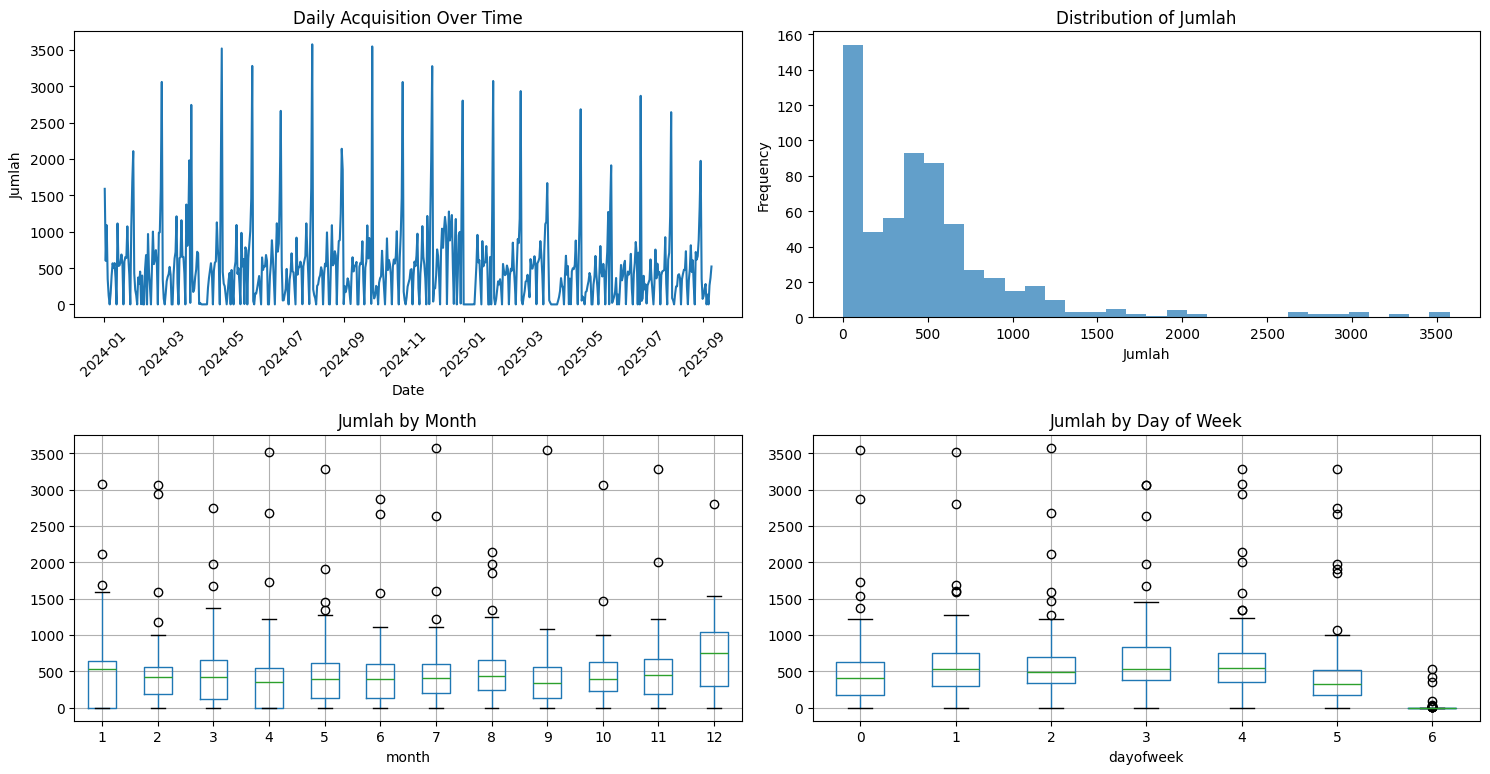

In [ ]:
# Visualize the data
plt.figure(figsize=(15, 8))
# Subplot pertama: Grafik garis jumlah akuisisi dari waktu ke waktu
plt.subplot(2, 2, 1)
plt.plot(df['tanggal'], df['jumlah'])
plt.title('Daily Acquisition Over Time')
plt.xlabel('Date')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)

# Subplot kedua: Histogram distribusi kolom 'jumlah'
plt.subplot(2, 2, 2)
plt.hist(df['jumlah'], bins=30, alpha=0.7)
plt.title('Distribution of Jumlah')
plt.xlabel('Jumlah')
plt.ylabel('Frequency')

# Subplot ketiga: Box plot kolom 'jumlah' per bulan
plt.subplot(2, 2, 3)
df.boxplot(column='jumlah', by='month', ax=plt.gca())
plt.title('Jumlah by Month')
plt.suptitle('') # Menghilangkan judul utama otomatis dari boxplot

# Subplot keempat: Box plot kolom 'jumlah' per hari dalam seminggu
plt.subplot(2, 2, 4)
df.boxplot(column='jumlah', by='dayofweek', ax=plt.gca())
plt.title('Jumlah by Day of Week')
plt.suptitle('') # Menghilangkan judul utama otomatis dari boxplot

# Menyesuaikan tata letak subplot agar tidak tumpang tindih
plt.tight_layout()
# Menampilkan plot
plt.show()

# **Prophet Tanpa Validasi**

In [ ]:
# Prophet end-to-end pipeline: training, accuracy, forecasting, visualization, export

# Import library Prophet dan modul diagnostics (meskipun hanya fungsi metrik yang digunakan)
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Siapkan data untuk Prophet: ganti nama kolom 'tanggal' menjadi 'ds' dan 'jumlah' menjadi 'y'
df_prophet = df[['tanggal', 'jumlah']].rename(columns={'tanggal': 'ds', 'jumlah': 'y'})

# Bagi data menjadi set latih (train) dan uji (test) berdasarkan proporsi waktu (30% data terakhir untuk uji)
split_index = int(len(df_prophet) * (1 - TEST_SIZE))
train_df = df_prophet.iloc[:split_index].copy() # Data latih
test_df = df_prophet.iloc[split_index:].copy()   # Data uji

# Parameter konfigurasi untuk model Prophet dengan floor constraint
PROPHET_PARAMS = {
    'growth': 'linear',             # Jenis pertumbuhan: linear
    'seasonality_mode': 'additive', # Mode musiman: aditif
    'weekly_seasonality': True,     # Aktifkan musiman mingguan
    'yearly_seasonality': True,     # Aktifkan musiman tahunan
    'daily_seasonality': False,     # Nonaktifkan musiman harian (data harian mungkin tidak menunjukkan pola harian yang kuat jika tidak ada data 24/7)
}

# Inisialisasi model Prophet dengan parameter dan hari libur
m = Prophet(**PROPHET_PARAMS, holidays=holidays_df)

# Tambahkan komponen musiman bulanan khusus (periode sekitar 30.5 hari, 7 orde Fourier)
m.add_seasonality(name='monthly', period=30.5, fourier_order=7)

# Latih model Prophet menggunakan set data latih
m.fit(train_df)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp8namg2e5/nkconbx3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8namg2e5/mpyeoj4v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66551', 'data', 'file=/tmp/tmp8namg2e5/nkconbx3.json', 'init=/tmp/tmp8namg2e5/mpyeoj4v.json', 'output', 'file=/tmp/tmp8namg2e5/prophet_modeltvg6ywnx/prophet_model-20250918014449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:44:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## **Evaluasi Model**

In [ ]:
# === Evaluasi pada Data Latih (In-sample prediction) ===

# Buat prediksi pada data latih untuk menghitung MAPE train
future_train = pd.DataFrame({'ds': train_df['ds']})
future_train['floor'] = 0  # Floor constraint untuk mencegah prediksi negatif

forecast_train = m.predict(future_train)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
# Terapkan floor constraint
forecast_train['yhat'] = np.maximum(forecast_train['yhat'], 0)
forecast_train['yhat_lower'] = np.maximum(forecast_train['yhat_lower'], 0)

# Gabungkan hasil prediksi dengan nilai aktual dari set data latih
results_train = train_df.merge(forecast_train, on='ds', how='left')

# === Evaluasi pada Data Uji (Out-of-sample prediction) ===

# Buat DataFrame masa depan yang hanya berisi tanggal-tanggal dari set data uji
future_test = pd.DataFrame({'ds': test_df['ds']})
# Pastikan batas bawah adalah 0 untuk prediksi
future_test['floor'] = 0

# Buat prediksi menggunakan model pada tanggal data uji
# Ambil kolom 'ds', 'yhat' (prediksi), 'yhat_lower', dan 'yhat_upper' (interval kepercayaan)
# Terapkan batas bawah 0 pada prediksi
forecast_test = m.predict(future_test)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_test['yhat'] = np.maximum(forecast_test['yhat'], 0)
forecast_test['yhat_lower'] = np.maximum(forecast_test['yhat_lower'], 0)

# Gabungkan hasil prediksi dengan nilai aktual dari set data uji untuk perbandingan
results_test = test_df.merge(forecast_test, on='ds', how='left')

# === Hitung Metrik Akurasi ===

def calculate_mape(y_true, y_pred):
    """Calculate MAPE, handling cases where y_true is zero."""
    # Filter out zero values to avoid division by zero
    non_zero_indices = y_true > 0
    if np.sum(non_zero_indices) == 0:
        return np.nan # Return NaN if all actual values are zero
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

def calculate_smape(y_true, y_pred):
    """Calculate SMAPE, handling cases where y_true + y_pred is zero."""
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Handle cases where denominator is zero
    # Set the error to 0 where both y_true and y_pred are 0
    ratio = np.where(denominator == 0, 0, numerator / denominator)
    return np.mean(ratio) * 100


# Hitung metrik untuk data latih
train_rmse = np.sqrt(mean_squared_error(results_train['y'], results_train['yhat']))
train_mae = mean_absolute_error(results_train['y'], results_train['yhat'])
train_mape = calculate_mape(results_train['y'].values, results_train['yhat'].values)
train_smape = calculate_smape(results_train['y'].values, results_train['yhat'].values)


# Hitung metrik untuk data uji
test_rmse = np.sqrt(mean_squared_error(results_test['y'], results_test['yhat']))
test_mae = mean_absolute_error(results_test['y'], results_test['yhat'])
test_mape = calculate_mape(results_test['y'].values, results_test['yhat'].values)
test_smape = calculate_smape(results_test['y'].values, results_test['yhat'].values)

# Cetak hasil metrik akurasi
print("Train accuracy (Prophet):")
print(f"- RMSE: {train_rmse:.2f}")
print(f"- MAE:  {train_mae:.2f}")
print(f"- MAPE: {train_mape:.2f}%")
print(f"- SMAPE: {train_smape:.2f}%")

print("\nTest accuracy (Prophet):")
print(f"- RMSE: {test_rmse:.2f}")
print(f"- MAE:  {test_mae:.2f}")
print(f"- MAPE: {test_mape:.2f}%")
print(f"- SMAPE: {test_smape:.2f}%")

Train accuracy (Prophet):
- RMSE: 375.29
- MAE:  202.19
- MAPE: 411.04%
- SMAPE: 50.69%

Test accuracy (Prophet):
- RMSE: 354.12
- MAE:  189.30
- MAPE: 178.50%
- SMAPE: 46.27%


## **Visualisasi Hasil**

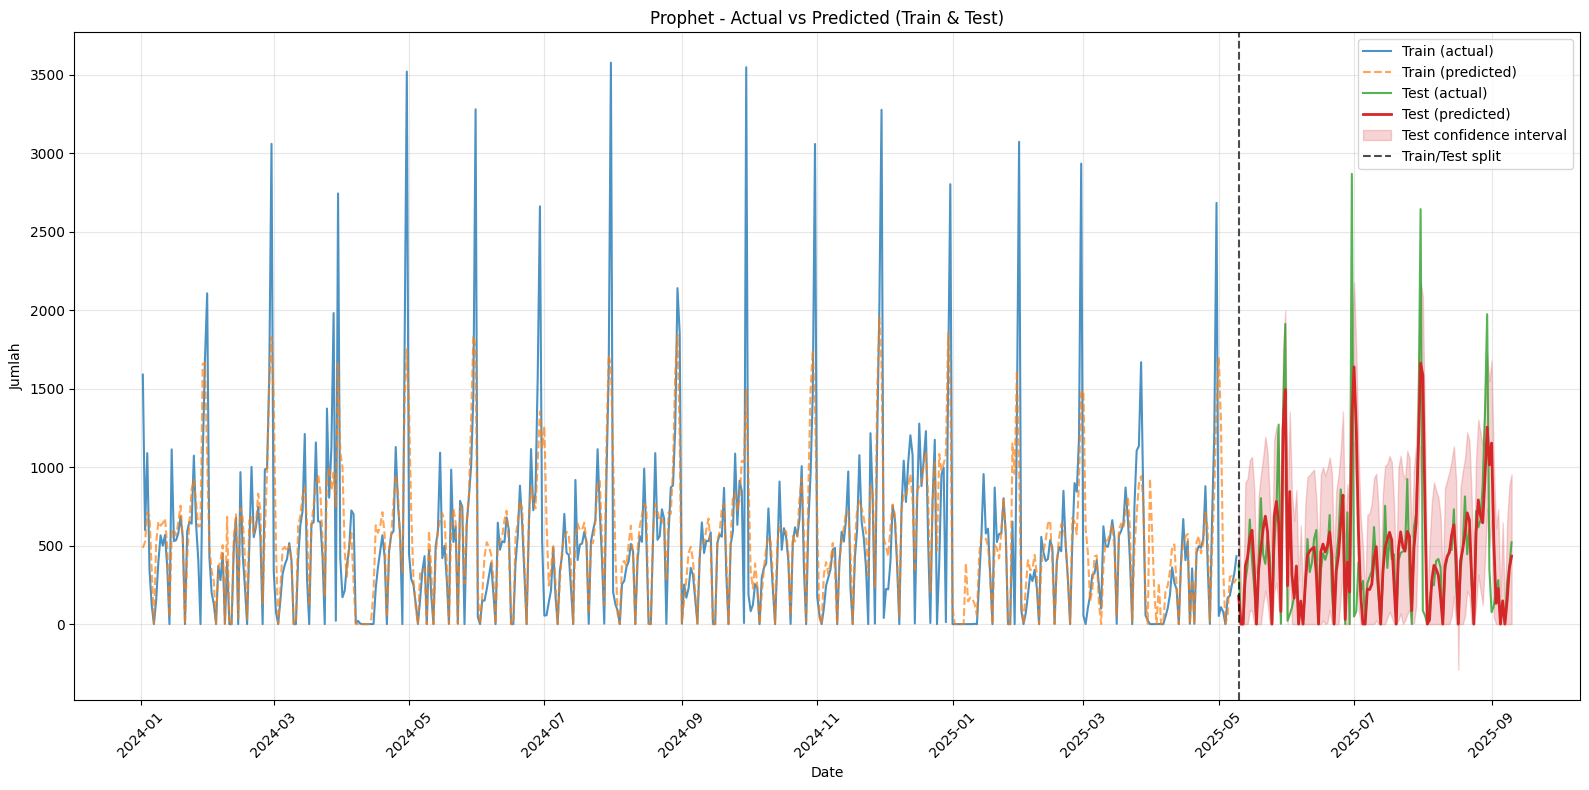

In [ ]:
# === Visualisasi Hasil ===

# Buat plot untuk membandingkan data aktual dan prediksi
plt.figure(figsize=(16,8))

# Plot data latih aktual
plt.plot(train_df['ds'], train_df['y'], label='Train (actual)', color='tab:blue', alpha=0.8)
# Plot prediksi pada data latih
plt.plot(results_train['ds'], results_train['yhat'], label='Train (predicted)', color='tab:orange', alpha=0.7, linestyle='--')

# Plot data uji aktual
plt.plot(test_df['ds'], test_df['y'], label='Test (actual)', color='tab:green', alpha=0.8)
# Plot garis prediksi (yhat) pada data uji
plt.plot(results_test['ds'], results_test['yhat'], label='Test (predicted)', color='tab:red', linewidth=2)

# Isi area antara batas bawah dan atas interval kepercayaan (yhat_lower, yhat_upper)
plt.fill_between(results_test['ds'], results_test['yhat_lower'], results_test['yhat_upper'],
                 color='tab:red', alpha=0.2, label='Test confidence interval')

# Tambahkan garis vertikal untuk memisahkan train dan test
plt.axvline(x=test_df['ds'].iloc[0], color='black', linestyle='--', alpha=0.7, label='Train/Test split')

# Tambahkan judul dan label sumbu
plt.title('Prophet - Actual vs Predicted (Train & Test)')
plt.xlabel('Date'); plt.ylabel('Jumlah'); plt.legend(); plt.grid(True, alpha=0.3)
# Rotasi label sumbu x agar lebih mudah dibaca
plt.xticks(rotation=45); plt.tight_layout(); plt.show()



## **Forecast**

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8namg2e5/tquvcjvk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8namg2e5/y8p1d1t9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82352', 'data', 'file=/tmp/tmp8namg2e5/tquvcjvk.json', 'init=/tmp/tmp8namg2e5/y8p1d1t9.json', 'output', 'file=/tmp/tmp8namg2e5/prophet_modelilmts_af/prophet_model-20250918014451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:44:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


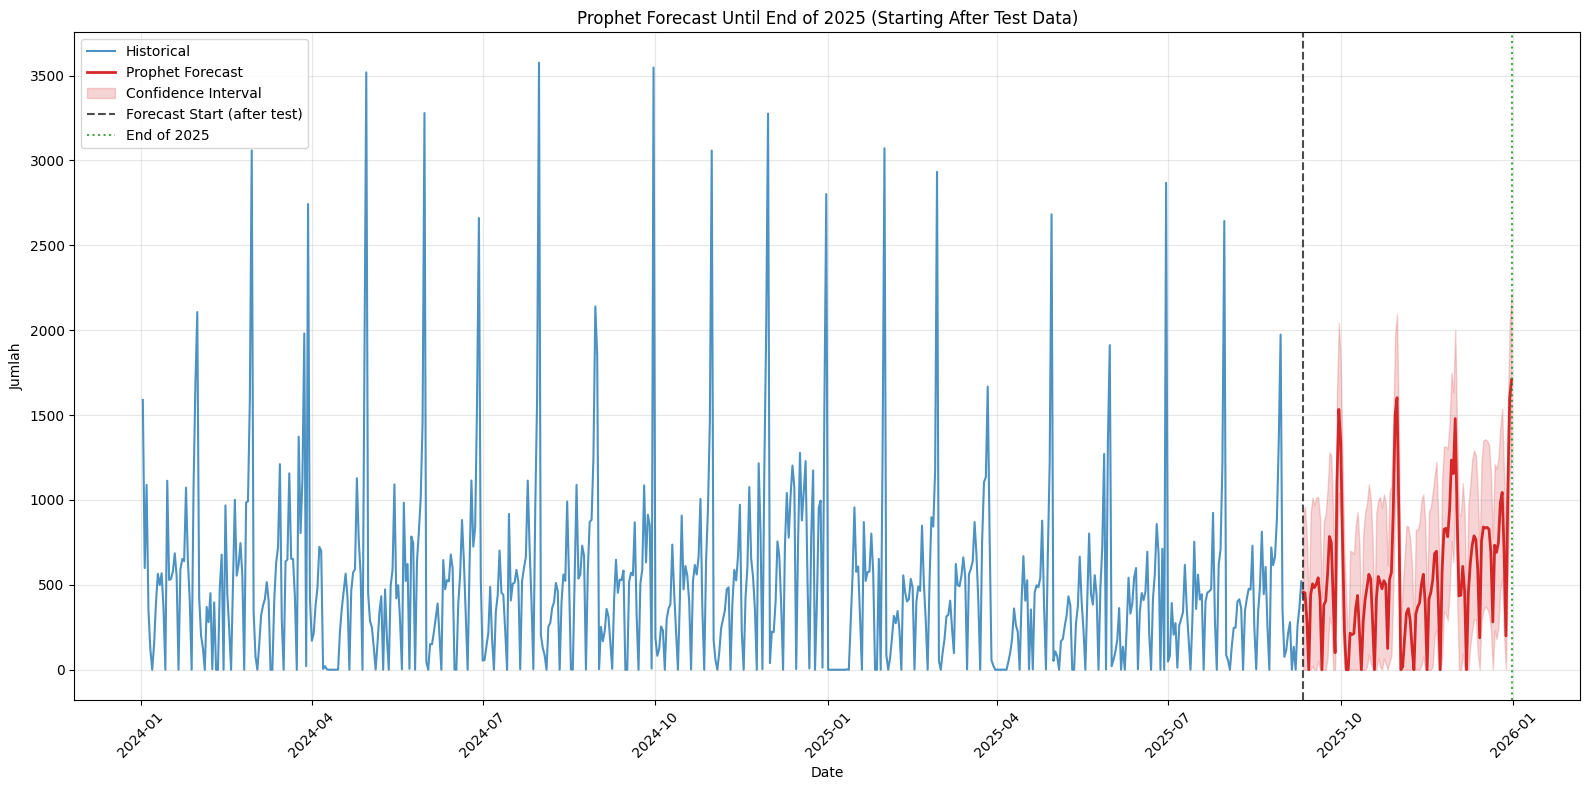

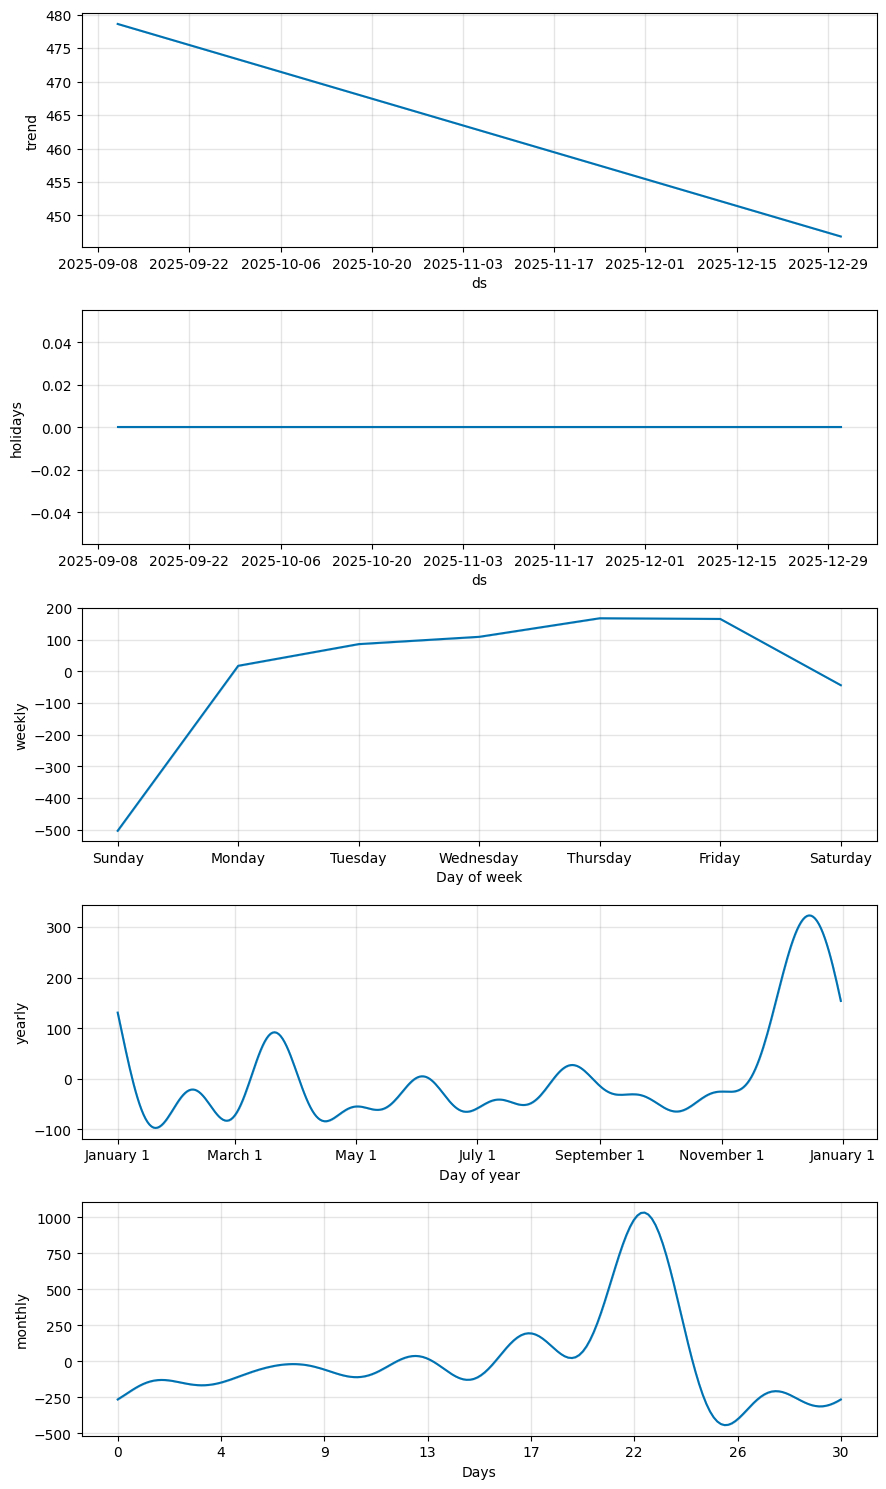

Forecast saved to prophet_forecast_until_2025_tanpa validasi.csv
      date   forecast     lower       upper  year  month  day  day_name  quarter
2025-09-11 457.221480  0.000000  911.996622  2025      9   11  Thursday        3
2025-09-12 452.471734  0.000000  960.144328  2025      9   12    Friday        3
2025-09-13 290.654520  0.000000  770.851875  2025      9   13  Saturday        3
2025-09-14   0.000000  0.000000  368.704912  2025      9   14    Sunday        3
2025-09-15 442.154020  0.000000  922.150090  2025      9   15    Monday        3
2025-09-16 505.838936 21.276770 1013.769604  2025      9   16   Tuesday        3
2025-09-17 483.582436  0.000000  969.633262  2025      9   17 Wednesday        3
2025-09-18 504.506899  0.000000 1014.480254  2025      9   18  Thursday        3
2025-09-19 541.688349 54.233774 1016.934904  2025      9   19    Friday        3
2025-09-20 418.864896  0.000000  893.122884  2025      9   20  Saturday        3


In [ ]:
# === Peramalan Penuh hingga Akhir 2025 ===

# Dapatkan tanggal terakhir dari data uji
last_test_date = test_df['ds'].max()
# Tentukan tanggal akhir peramalan (Akhir 2025)
end_of_2025 = pd.Timestamp('2025-12-31')
# Hitung jumlah hari yang tersisa untuk peramalan (dari tanggal terakhir data uji hingga akhir 2025)
forecast_days_from_test_end = max(0, (end_of_2025 - last_test_date).days)

# Mulai dari hari setelah tanggal terakhir data uji
future_start_date = last_test_date + pd.Timedelta(days=1)
future_dates = pd.date_range(start=future_start_date, end=end_of_2025, freq='D')
future_df = pd.DataFrame({'ds': future_dates})

# Tambahkan kolom 'floor' dengan nilai 0 untuk memastikan prediksi tidak negatif
future_df['floor'] = 0
# Buat prediksi pada DataFrame masa depan (termasuk data historis dan masa depan)
# Latih ulang model pada seluruh data historis (train + test) sebelum memprediksi masa depan
m_full_data = Prophet(**PROPHET_PARAMS, holidays=holidays_df)
m_full_data.add_seasonality(name='monthly', period=30.5, fourier_order=7)
m_full_data.fit(df_prophet)

forecast_full = m_full_data.predict(future_df)
# Terapkan clipping untuk memastikan yhat dan yhat_lower tidak negatif
forecast_full['yhat'] = np.maximum(forecast_full['yhat'], 0)
forecast_full['yhat_lower'] = np.maximum(forecast_full['yhat_lower'], 0)
# Filter hasil prediksi hanya untuk tanggal-tanggal di masa depan
future_only = forecast_full[['ds','yhat','yhat_lower','yhat_upper']].copy()


# === Visualisasi Peramalan Penuh ===

# Buat plot yang menampilkan data historis dan peramalan penuh
plt.figure(figsize=(16,8))
# Plot data historis
plt.plot(df_prophet['ds'], df_prophet['y'], label='Historical', color='tab:blue', alpha=0.8)
# Plot garis prediksi (yhat) untuk seluruh periode (historis + forecast)
plt.plot(forecast_full['ds'], forecast_full['yhat'], label='Prophet Forecast', color='tab:red', linewidth=2)
# Isi area interval kepercayaan untuk seluruh periode
plt.fill_between(forecast_full['ds'], forecast_full['yhat_lower'], forecast_full['yhat_upper'],
                 color='tab:red', alpha=0.2, label='Confidence Interval')
# Tambahkan garis vertikal putus-putus untuk menandai awal periode peramalan
plt.axvline(x=last_test_date + pd.Timedelta(days=1), color='black', linestyle='--', alpha=0.7, label='Forecast Start (after test)')
# Tambahkan garis vertikal titik-titik untuk menandai akhir tahun 2025
plt.axvline(x=end_of_2025, color='green', linestyle=':', alpha=0.7, label='End of 2025')
# Tambahkan judul dan label sumbu
plt.title('Prophet Forecast Until End of 2025 (Starting After Test Data)')
plt.xlabel('Date'); plt.ylabel('Jumlah'); plt.legend(); plt.grid(True, alpha=0.3)
# Rotasi label sumbu x dan atur tata letak
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# === Visualisasi Komponen Model Prophet ===

# Plot komponen-komponen musiman dan tren dari model Prophet
fig = m_full_data.plot_components(forecast_full)
plt.show()

# === Ekspor Hasil Peramalan Masa Depan ===

# Cek apakah ada data peramalan masa depan
if len(future_only) > 0:
    # Buat salinan DataFrame future_only untuk ekspor
    out = future_only.copy()
    # Ganti nama kolom agar lebih deskriptif
    out = out.rename(columns={'ds':'date','yhat':'forecast','yhat_lower':'lower','yhat_upper':'upper'})
    # Tambahkan kolom-kolom informasi tanggal (tahun, bulan, hari, nama hari, kuartal)
    out['year'] = out['date'].dt.year
    out['month'] = out['date'].dt.month
    out['day'] = out['date'].dt.day
    out['day_name'] = out['date'].dt.day_name()
    out['quarter'] = out['date'].dt.quarter
    # Simpan DataFrame ke file CSV tanpa indeks
    out.to_csv('prophet_forecast_until_2025_tanpa validasi.csv', index=False)
    # Cetak pesan konfirmasi penyimpanan file
    print('Forecast saved to prophet_forecast_until_2025_tanpa validasi.csv')
    # Cetak 10 baris pertama dari file CSV yang diekspor (tanpa indeks)
    print(out.head(10).to_string(index=False))
else:
    print('No future forecast data to export.')

## **Summary**

In [ ]:
# === Ringkasan Akhir ===

# Cetak ringkasan kinerja model dan informasi peramalan
print('\n== Prophet Summary ==')
# Cetak ukuran set data (latih, uji, total)
print(f'Train size: {len(train_df)} | Test size: {len(test_df)} | Total: {len(df_prophet)}')
# Cetak metrik akurasi pada data latih
print(f'Train RMSE={train_rmse:.4f}, MAE={train_mae:.4f}, ', end='')
print(f"MAPE: {train_mape:.2f}%, SMAPE: {train_smape:.2f}%")

# Cetak metrik akurasi pada data uji
print(f'Test RMSE={test_rmse:.4f}, MAE={test_mae:.4f}, ', end='')
print(f"MAPE: {test_mape:.2f}%, SMAPE: {test_smape:.2f}%")

# Jika ada peramalan masa depan, cetak jumlah hari, tanggal mulai, dan tanggal akhir peramalan
if len(future_only) > 0:
    print(f'Future days: {len(future_only)}; Start: {(last_test_date + pd.Timedelta(days=1)).date()} | End: {end_of_2025.date()}')
else:
    print('No future forecast data available.')


== Prophet Summary ==
Train size: 494 | Test size: 124 | Total: 618
Train RMSE=375.2950, MAE=202.1941, MAPE: 411.04%, SMAPE: 50.69%
Test RMSE=354.1239, MAE=189.3034, MAPE: 178.50%, SMAPE: 46.27%
Future days: 112; Start: 2025-09-11 | End: 2025-12-31


# **Peramalan Tiap Bulan**


Peramalan Bulanan (September - Desember 2025)
    Bulan       Jumlah
September 12099.849993
  Oktober 14791.594373
 November 14300.567628
 Desember 23004.291849


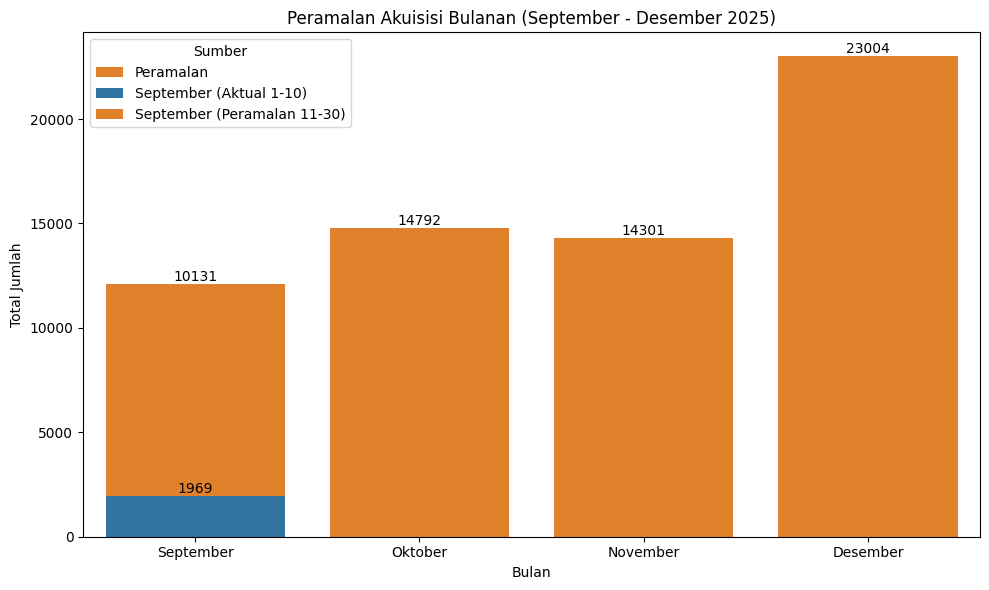

In [19]:
# === Peramalan Tiap Bulan ===

# Filter data aktual untuk September 2025 (hingga tanggal 10)
sept_2025_actual = df[(df['tanggal'] >= '2025-09-01') & (df['tanggal'] <= '2025-09-10')].copy()

# Filter data forecast untuk September 2025 (dari tanggal 11 hingga akhir bulan) dan sisa bulan tahun 2025
sept_dec_2025_forecast = future_only[(future_only['ds'] >= '2025-09-11') & (future_only['ds'] <= '2025-12-31')].copy()

# Hitung total aktual untuk 1-10 September
total_sept_actual = sept_2025_actual['jumlah'].sum()

# Hitung total forecast untuk 11-30 September
total_sept_forecast = sept_dec_2025_forecast[sept_dec_2025_forecast['ds'] <= '2025-09-30']['yhat'].sum()

# Gabungkan data aktual September (1-10) dan data forecast September (11-30) untuk total September
total_sept_2025 = total_sept_actual + total_sept_forecast

# Agregasi data forecast untuk Oktober, November, dan Desember 2025 per bulan
monthly_forecast_oct_dec = sept_dec_2025_forecast[(sept_dec_2025_forecast['ds'].dt.month >= 10) & (sept_dec_2025_forecast['ds'].dt.month <= 12)].copy()
monthly_forecast_oct_dec['month'] = monthly_forecast_oct_dec['ds'].dt.month
monthly_forecast_oct_dec_agg = monthly_forecast_oct_dec.groupby('month')['yhat'].sum().reset_index()

# Buat DataFrame hasil bulanan
monthly_forecast_summary = pd.DataFrame({
    'Bulan': ['September', 'Oktober', 'November', 'Desember'],
    'Jumlah': [total_sept_2025,
               monthly_forecast_oct_dec_agg[monthly_forecast_oct_dec_agg['month'] == 10]['yhat'].sum(),
               monthly_forecast_oct_dec_agg[monthly_forecast_oct_dec_agg['month'] == 11]['yhat'].sum(),
               monthly_forecast_oct_dec_agg[monthly_forecast_oct_dec_agg['month'] == 12]['yhat'].sum()]
})

# Tampilkan tabel bulanan
print("\nPeramalan Bulanan (September - Desember 2025)")
# Cetak tabel tanpa indeks
print(monthly_forecast_summary.to_string(index=False))

# === Visualisasi Bar Chart Bulanan dengan Pembagian September ===

# Siapkan data untuk bar chart bertumpuk untuk September
sept_split_data = pd.DataFrame({
    'Bulan': ['September', 'September'],
    'Sumber': ['Aktual (1-10)', 'Peramalan (11-30)'],
    'Jumlah': [total_sept_actual, total_sept_forecast]
})

# Siapkan data untuk Oktober, November, dan Desember
other_months_data = monthly_forecast_summary[monthly_forecast_summary['Bulan'] != 'September'].copy()
other_months_data['Sumber'] = 'Peramalan' # Label ini sebagai peramalan murni

# Gabungkan data untuk plotting
# Kita perlu memplot September sebagai bar bertumpuk dan bulan lainnya sebagai bar tunggal
# Ini memerlukan sedikit plotting manual atau mengubah bentuk data
# Mari kita buat dataframe gabungan yang cocok untuk plotting dengan warna berbeda

# Buat dataframe untuk bar bertumpuk September
sept_plot_data = pd.DataFrame({
    'Bulan': ['September', 'September'],
    'Jumlah': [total_sept_actual, total_sept_forecast],
    'Sumber': ['Aktual (1-10)', 'Peramalan (11-30)']
})

# Buat dataframe untuk bulan-bulan lainnya
other_months_plot_data = monthly_forecast_summary[monthly_forecast_summary['Bulan'] != 'September'].copy()
other_months_plot_data['Sumber'] = 'Peramalan' # Tetapkan sumber untuk pewarnaan

# Untuk plotting, kita bisa menggunakan dataframe gabungan dan menangani penumpukan/pewarnaan
# secara manual atau menggunakan fitur library plotting jika tersedia.
# Mari kita buat dataframe tunggal di mana September direpresentasikan oleh dua baris
# dan bulan lainnya oleh satu baris masing-masing, dengan kolom 'Sumber' untuk pewarnaan.

combined_plot_df = pd.concat([
    sept_plot_data,
    other_months_plot_data
]).reset_index(drop=True)

# Pastikan bulan-bulan dalam urutan yang benar untuk plotting
combined_plot_df['Bulan'] = pd.Categorical(combined_plot_df['Bulan'], categories=['September', 'Oktober', 'November', 'Desember'], ordered=True)
combined_plot_df = combined_plot_df.sort_values('Bulan')


plt.figure(figsize=(10, 6))

# Plot Oktober, November, Desember sebagai bar tunggal
ax = sns.barplot(data=combined_plot_df[combined_plot_df['Bulan'] != 'September'],
            x='Bulan', y='Jumlah', color=sns.color_palette()[1], label='Peramalan') # Gunakan satu warna untuk peramalan

# Plot September sebagai bar bertumpuk
# Kita perlu memplot bagian 'Aktual' terlebih dahulu, lalu bagian 'Peramalan' di atasnya
sns.barplot(data=combined_plot_df[(combined_plot_df['Bulan'] == 'September') & (combined_plot_df['Sumber'] == 'Aktual (1-10)')],
            x='Bulan', y='Jumlah', color=sns.color_palette()[0], label='September (Aktual 1-10)', ax=ax) # Biru untuk Aktual

sns.barplot(data=combined_plot_df[(combined_plot_df['Bulan'] == 'September') & (combined_plot_df['Sumber'] == 'Peramalan (11-30)')],
            x='Bulan', y='Jumlah', color=sns.color_palette()[1], bottom=combined_plot_df[(combined_plot_df['Bulan'] == 'September') & (combined_plot_df['Sumber'] == 'Aktual (1-10)')]['Jumlah'].values, label='September (Peramalan 11-30)', ax=ax) # Oranye untuk Peramalan

# Tambahkan label data
for container in ax.containers:
    labels = [f'{int(round(j.get_height()))}' if j.get_height() > 0 else '' for j in container]
    ax.bar_label(container, labels=labels, label_type='edge')


plt.title('Peramalan Akuisisi Bulanan (September - Desember 2025)')
plt.xlabel('Bulan')
plt.ylabel('Total Jumlah')
plt.legend(title='Sumber')
plt.tight_layout()
plt.show()